In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Fourier Neural Operator (FNO)

Neural Operators (NOs) generalize Deep Neural Networks to $∞$-dimensions.

## What are Deep Neural Networks (DNNs)?
A single hidden layer of a DNN is given by:

$\sigma_{K}(y) = \sigma(A_{K}Y+B)$.

Therefore a DNN is a recursive relation given by:

$\mathcal{L}_{\theta} = \sigma_K \odot \sigma_{K-1} \odot \cdots \odot \sigma_1$

A NO is described by the following recursive relation:

$\mathcal{N}_{\theta} = \mathcal{N}_{L} \odot \mathcal{N}_{L-1} \odot \cdots \odot \mathcal{N}_{1}$

FNO consists of:


1.   Lifting Layer ($1 \times 1$ Convolution).
2.   Multiple blocks of Spectral Convolutions with a Bypass.
3.   Projection Layer ($1 \times 1$ Convolution).

Block operation:
$$b = \verb|activation|(\tilde{a}+\verb|Conv|_{1\times 1}(a))$$



# 1D [Burgers' Equation](https://https://en.wikipedia.org/wiki/Burgers%27_equation)

The purpose of this notebook is to introduce you to coding the FNO using JAX. It is recommended that you use Google Colab with GPU to run this notebook as the training can take upto 30 minutes in CPU.

The Burger's equation is described by the following PDE.

$$\frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

The boundary conditions are provided by:
*   $\Omega = (0, 2\pi)$.
*   $u(t,x=0)=u(t,x=2\pi)$.
*   $\nu=0.1$.



In [23]:
# Import Libraries
import jax
import jax.numpy as jnp
import optax
from typing import Callable, List
import scipy
try:
  import equinox as eqx
except:
  !pip install equinox --quiet
  import equinox as eqx
from tqdm.autonotebook import tqdm

<ipython-input-23-a502d726e4e7>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


The dataset consists of $a=2048$ initial conditions $u(t=0,x)$ on a $N=8192$ resolution together with their solution at time $u(t=1,x)$

In [3]:
# Download Dataset
# Mathworks (the creators of Matlab) host the original Li et al. dataset in the .mat format
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2024-11-07 21:47:29--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.12.87.41
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.12.87.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  68.4MB/s    in 11s     

2024-11-07 21:47:41 (57.2 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [4]:
# Load the .mat file in python environment
data = scipy.io.loadmat('burgers_data_R10.mat')

In [5]:
# Extract the initial conditions (inputs) and outputs from the dataset
a, u = data['a'], data['u']
print(f"Shape of a (Number of Samples, Discretization): {a.shape}")
print(f"Shape of u (Number of Samples, Discretization): {u.shape}")

Shape of a (Number of Samples, Discretization): (2048, 8192)
Shape of u (Number of Samples, Discretization): (2048, 8192)


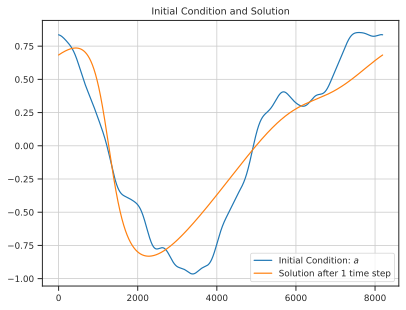

In [6]:
fig, ax = plt.subplots()
ax.plot(a[0], label="Initial Condition: $a$")
ax.plot(u[0], label="Solution after 1 time step")
ax.legend()
ax.set_title("Initial Condition and Solution")
ax.grid(True)
plt.show()

In [7]:
# Add channel dimension
# This changes the shape of `a` and `u` from (batch_size, sequence_length)
# to (batch_size, 1, sequence_length), adding a channel dimension in the middle.
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]

In [8]:
# The dataset is preconcatenated with the mesh.
# Mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2 * jnp.pi, u.shape[-1])

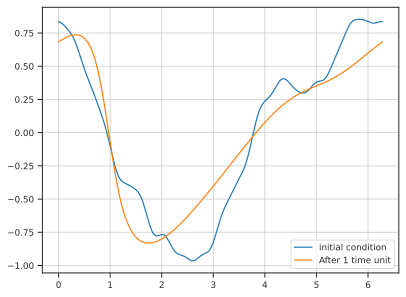

In [9]:
fig, ax = plt.subplots()
ax.plot(mesh, a[0, 0], label="initial condition")
ax.plot(mesh, u[0, 0], label="After 1 time unit")
ax.legend()
ax.grid()

In [10]:
# Adjust the shape of `mesh` to match the batch dimension of `u`
# - First, add two new axes to `mesh` using `jnp.newaxis` to reshape it to (1, 1, mesh_length)
# - Then, repeat `mesh` along the batch dimension (axis=0) to create a shape of (batch_size, 1, mesh_length)
# - This ensures `mesh_shape_corrected` matches the shape of `a` in the batch dimension
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u.shape[0], axis=0)

# Concatenate `a` and `mesh_shape_corrected` along the channel dimension (axis=1)
# - This combines `a` with the reshaped `mesh`, resulting in a shape of (batch_size, 2, sequence_length)
# - The second dimension now includes both `a` and `mesh` as separate "channels"
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)

In [11]:
# Check shape
a_with_mesh.shape

(2048, 2, 8192)

In [12]:
# Extract training and test data
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [13]:
print(f"Shape of train_x: {train_x.shape}")
print(f"Shape of train_y: {test_x.shape}")

Shape of train_x: (1000, 2, 8192)
Shape of train_y: (200, 2, 8192)


In [14]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array # Real part of spectral weights
    imag_weights: jax.Array # Imaginary part of spectral weights
    in_channels: int        # Number of input channels
    out_channels: int       # Number of output channels
    modes: int              # Number of frequency modes to use

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        # Initialize input, output channels and number of modes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        # Scaling factor for weight initialization
        scale = 1.0 / (in_channels * out_channels)

        # Split key for separate initialization of real and imaginary parts
        real_key, imag_key = jax.random.split(key)
        # Initialize real part of weights with uniform distribution
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        # Initialize imaginary part of weights with uniform distribution
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        # Perform complex multiplication along frequency modes
        # x_hat has shape (in_channels, modes), w has shape (in_channels, out_channels, modes)
        # Resulting shape is (out_channels, modes)
        return jnp.einsum("iM,ioM->oM", x_hat, w)


    def __call__(
            self,
            x,
    ):
        # Input x shape: (in_channels, spatial_points)
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        # Compute FFT of input along the spatial dimension
        x_hat = jnp.fft.rfft(x)
        # shape of x_hat_under_modes is (in_channels, self.modes)
        # Truncate the frequency representation to keep only the specified modes
        x_hat_under_modes = x_hat[:, :self.modes]
        # Combine real and imaginary weights to form complex weights
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        # Apply complex multiplication to obtain output in frequency space
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        # Initialize the full output in the frequency domain
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )
        # Insert the computed modes back into the output
        # Only the first 'modes' entries are set, others remain zero
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        # Perform the inverse FFT to return to spatial domain
        # Output shape: (out_channels, spatial_points)
        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out

In [15]:
class FNOBlock1d(eqx.Module):
    # Define the module attributes
    spectral_conv: SpectralConv1d  # Spectral convolution layer
    bypass_conv: eqx.nn.Conv1d     # Bypass convolution layer for residual connection
    activation: Callable           # Activation function for the layer output

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        # Split the random key for initializing the spectral and bypass convolutions separately
        spectral_conv_key, bypass_conv_key = jax.random.split(key)

        # Initialize spectral convolution layer with given parameters and modes
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )

        # Initialize bypass convolution layer with a kernel size of 1 for pointwise convolution
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one (pointwise convolution)
            key=bypass_conv_key,
        )

        # Set the activation function (e.g., ReLU, tanh)
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        # Perform the forward pass
        # Apply spectral convolution and bypass convolution to input x
        # Add the results to create a residual connection, then apply activation function
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )


In [16]:
class FNO1d(eqx.Module):
    # Define the module attributes
    lifting: eqx.nn.Conv1d        # Initial convolution to lift input to desired channel width
    fno_blocks: List[FNOBlock1d]  # Sequence of FNO blocks to apply transformations
    projection: eqx.nn.Conv1d     # Final convolution to project output to desired shape

    def __init__(
            self,
            in_channels,   # Number of input channels
            out_channels,  # Number of output channels
            modes,         # Number of frequency modes for spectral convolution
            width,         # Width (number of channels) in FNO blocks
            activation,    # Activation function to use in FNO blocks
            n_blocks=4,    # Number of FNO blocks
            *,
            key,           # Random key for initialization
    ):
        # Split the random key for initializing the lifting layer
        key, lifting_key = jax.random.split(key)

        # Initialize lifting layer (pointwise convolution) to map input to `width` channels
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,            # Kernel size of 1 (pointwise convolution)
            key=lifting_key,
        )

        # Initialize the sequence of FNO blocks
        self.fno_blocks = []
        for i in range(n_blocks):
            # Split key for each block to ensure unique initialization
            key, subkey = jax.random.split(key)

            # Append an FNO block with `width` channels and `modes` frequency modes
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))

        # Split key for initializing the projection layer
        key, projection_key = jax.random.split(key)

        # Initialize projection layer to map `width` channels to `out_channels`
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,  # Kernel size of 1 (pointwise convolution)
            key=projection_key,
        )

    def __call__(
            self,
            x,  # Input data of shape (in_channels, spatial_points)
    ):
        # Apply the lifting layer to increase input channels to `width`
        x = self.lifting(x)

        # Pass the input through each FNO block in sequence
        for fno_block in self.fno_blocks:
            x = fno_block(x)

        # Apply the projection layer to map to `out_channels`
        x = self.projection(x)

        # Return the final output
        return x


In [19]:
fno = FNO1d(
    in_channels=2,
    out_channels=1,
    modes=16,
    width=64,
    activation=jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [21]:
def dataloader(
    key,          # Random key for shuffling the dataset
    dataset_x,    # Input dataset (features), shape: (n_samples, ...)
    dataset_y,    # Output dataset (labels/targets), shape: (n_samples, ...)
    batch_size,   # Size of each batch
):
    # Get the number of samples in the dataset
    n_samples = dataset_x.shape[0]

    # Calculate the total number of batches needed
    n_batches = int(jnp.ceil(n_samples / batch_size))

    # Generate a random permutation of indices to shuffle the data
    permutation = jax.random.permutation(key, n_samples)

    # Yield each batch
    for batch_id in range(n_batches):
        # Calculate the start and end indices for the current batch
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        # Select the indices for the current batch from the permutation
        batch_indices = permutation[start:end]

        # Yield the shuffled batch of data for both x and y
        yield dataset_x[batch_indices], dataset_y[batch_indices]


In [24]:
def loss_fn(model, x, y):
    # Apply the model to each example in x to get predictions
    y_pred = jax.vmap(model)(x)

    # Calculate mean squared error (MSE) between predictions and true values y
    loss = jnp.mean(jnp.square(y_pred - y))

    # Return the calculated loss
    return loss

# Initialize the Adam optimizer with a learning rate of 3e-4
optimizer = optax.adam(3e-4)

# Initialize the optimizer state, filtering the model to only include parameters that are arrays
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    # Compute loss and gradients with respect to model parameters
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)

    # Calculate validation loss on a subset of test data
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])

    # Use optimizer to update model parameters with gradients
    updates, new_state = optimizer.update(grad, state, model)

    # Apply updates to the model parameters
    new_model = eqx.apply_updates(model, updates)

    # Return the updated model, new optimizer state, training loss, and validation loss
    return new_model, new_state, loss, val_loss

# Initialize lists to store loss history for training and validation
loss_history = []
val_loss_history = []

# Set random seed for data shuffling
shuffle_key = jax.random.PRNGKey(10)

# Training loop over a specified number of epochs
for epoch in tqdm(range(200)):
    # Split the random key for each epoch to ensure different shuffling
    shuffle_key, subkey = jax.random.split(shuffle_key)

    # Loop over each batch from the data loader
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],    # Use a subset of training data
        train_y[..., ::32],    # Use a subset of training labels
        batch_size=100,        # Define batch size
    ):
        # Perform a single optimization step and get the updated model, optimizer state, and losses
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)

        # Append the current training and validation losses to their respective histories
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

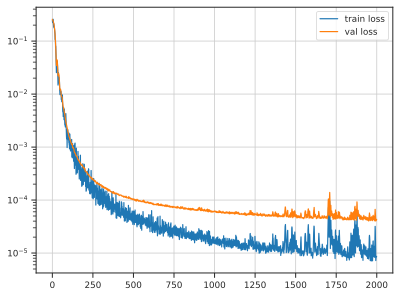

In [25]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

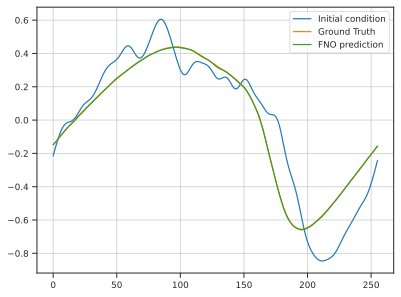

In [26]:
plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
plt.legend()
plt.grid()

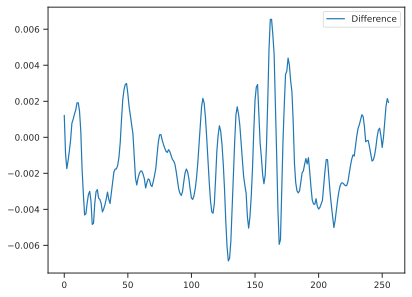

In [28]:
plt.plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Difference")
plt.legend()
plt.show()

Checking the claim of super-resolution

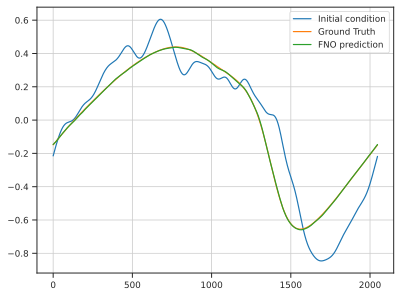

In [29]:
# Zero-Shot superresolution
plt.plot(test_x[1, 0, ::4], label="Initial condition")
plt.plot(test_y[1, 0, ::4], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")
plt.legend()
plt.grid()

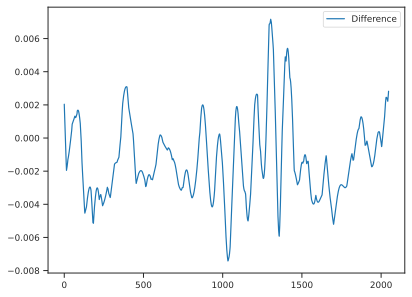

In [30]:
plt.plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Difference")
plt.legend()

In [31]:
# Compute the error as reported in the FNO paper
test_pred = jax.vmap(fno)(test_x)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)

In [32]:
jnp.mean(rel_l2_set) # ~1e-2

Array(0.00950829, dtype=float32)

[Source of Code](https://https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_FNO_in_JAX.ipynb)